In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
#C:\Users\tom\Documents\GitHub\strive-work\deep-learning\data\Cat_Dog_data
data_dir = "data/Cat_Dog_data"

In [3]:
ls data

 Volume in drive C has no label.
 Volume Serial Number is 32A6-1D16

 Directory of C:\Users\tom\Documents\GitHub\strive-work\deep-learning\data

02/06/2021  15:34    <DIR>          .
02/06/2021  15:34    <DIR>          ..
02/06/2021  15:35    <DIR>          Cat_Dog_data
02/06/2021  11:51    <DIR>          FashionMNIST
               0 File(s)              0 bytes
               4 Dir(s)  149,160,968,192 bytes free


In [4]:
# Apply a bunch of random effects to improve our data set, then convert to a tensor and normalize
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229,0.224,0.225])
])

In [5]:
import os
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transforms)

In [6]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_data, batch_size=3, shuffle=True)
testloader = DataLoader(test_data, batch_size=3, shuffle=False)

<AxesSubplot:>

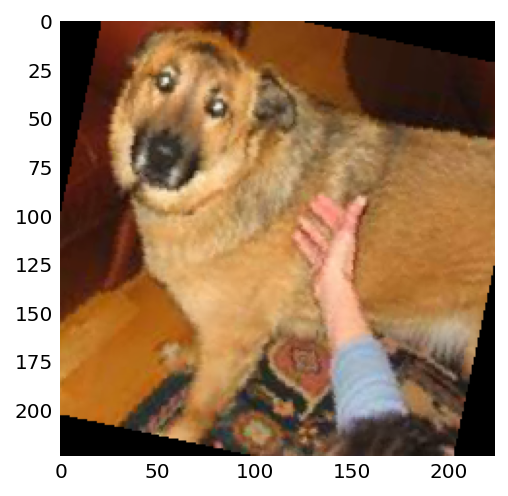

In [7]:
import numpy as np
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor"""
    if ax == None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.tick_params(axis="both", length=0)
    
    return ax

images, labels = next(iter(trainloader))
imshow(images[0])

In [8]:
labels

tensor([1, 0, 1])

In [9]:
train_data.class_to_idx

{'cat': 0, 'dog': 1}

In [10]:
model = models.densenet121(pretrained=True)
model
# Looks very complicated, just scroll to bottom and see "classifier", it will probably tell you what in_features you need

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [11]:
# We can borrow the rest of the model but change the classifier
# Freeze the conv layers, so we don't compute the gradients of the feature extractor
# We actually freeze everything here as we are replacing the classifier
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Let's make a new classifier
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ("fc1", nn.Linear(in_features=1024, out_features=64)),
    ("relu",nn.ReLU()),
    ("fc2",nn.Linear(in_features=64, out_features=10)),
    ("output", nn.LogSoftmax(dim=1)), 
]))

In [13]:
model.classifier = classifier

In [14]:
torch.cuda.is_available()
#model = model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)


In [21]:
model.to(device);

In [23]:
def train(dataloader, model, loss_function, optimizer):
    # X is the data, y is the target
    for batch, (X, y) in enumerate(dataloader):
        # This can be left out if you aren't using cuda, it just moves the tensors to GPU for processing
        X, y = X.to(device), y.to(device)
        # Make some predictions
        predictions = model(X)
        # Compute the loss
        loss = loss_function(predictions, y)
        # Backpropogate
        # Reset gradients, this is needed so that we are recalculating them each time we do this
        optimizer.zero_grad
        # Although we didn't define a backward() method, the model inherited it thanks to super()!
        loss.backward()
        # Update the parameters (weights and biases)
        optimizer.step()

        # Print some information so we can see what's happening
        size = len(dataloader.dataset)
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) # loss.item is the loss for the batch divided by batch size
            print(f"Loss: {loss}  [{current}/{size}")
            
def test(dataloader, model, loss_function):
    model.eval() # This sets the model to "evaluation mode", if we were using dropout this is required to test correctly
    test_loss, correct = 0, 0
    with torch.no_grad(): # This stops calculating the gradients, saves on memory usage for testing
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # Cuda stuff again
            predictions = model(X) # Make predictions
            test_loss += loss_function(predictions, y).item()
            correct += (predictions.argmax(1) == y).type(torch.float).sum().item() # I think this counts the correct predictions

        size = len(dataloader.dataset)
        test_loss /= size
        correct /= size
        print(f"Test Error:\nAccuracy: {(100*correct)}%\nAverage Loss: {test_loss}\n")

In [24]:
epochs = 3 # How many training cycles we do
for t in range(epochs):
    print(f"Epoch #{t+1}\n"+ ("-"*10))
    train(trainloader, model, criterion, optimizer)
    test(testloader, model, criterion)

print("Done!")

Epoch #1
----------
Loss: 0.7269046902656555  [0/22500
Loss: 0.6694692969322205  [300/22500
Loss: 0.6762697696685791  [600/22500
Loss: 0.7008398175239563  [900/22500
Loss: 0.680588960647583  [1200/22500
Loss: 0.7504815459251404  [1500/22500
Loss: 0.6107512712478638  [1800/22500
Loss: 0.7418044209480286  [2100/22500
Loss: 0.7415776252746582  [2400/22500
Loss: 0.6660462617874146  [2700/22500
Loss: 0.6393522620201111  [3000/22500
Loss: 0.6924350261688232  [3300/22500
Loss: 0.7104549407958984  [3600/22500
Loss: 0.7268306612968445  [3900/22500
Loss: 0.6596622467041016  [4200/22500
Loss: 0.7459936141967773  [4500/22500
Loss: 0.815180778503418  [4800/22500
Loss: 0.672476053237915  [5100/22500
Loss: 0.6969833374023438  [5400/22500
Loss: 0.7060330510139465  [5700/22500
Loss: 0.7663787007331848  [6000/22500
Loss: 0.6724473834037781  [6300/22500
Loss: 0.6742134690284729  [6600/22500
Loss: 0.7310793995857239  [6900/22500
Loss: 0.7033621668815613  [7200/22500
Loss: 0.6716668009757996  [7500/22500
L

KeyboardInterrupt: 